## Inference example file

In [1]:
# Important downloads to run out of the box
%pip install --upgrade pip
%pip install segmentation_models_pytorch
%pip install torch
%pip install tqdm
%pip install matplotlib
%pip install opencv-python
%pip install rasterio
%pip install pandas
%pip install scipy
%pip install -U scikit-learn
%pip install torchmetrics
%pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 29.1 MB/s  0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 10.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchmetrics]


In [1]:
# connect to my Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# import my Datasets
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/IPEO_Projet")


In [5]:
# standard imports
import os
import torch
import numpy as np
import random
from tqdm import tqdm
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# local imports
from models.utils.inference import run_eval
from models.DinoV3.SemanDino import GlacierSegmenter
from models.DinoV3.GlacierDataset import GlacierDataset
from models.utils.metrics import get_combined_loss, get_iou_metric

In [6]:
# Define paths
DATASET_ROOT = "dataset"
TRAIN_IMAGE_DIR = f"{DATASET_ROOT}/clean/images/"
TRAIN_MASK_DIR  = f"{DATASET_ROOT}/clean/masks/"
TEST_IMAGE_DIR  = f"{DATASET_ROOT}/test/images/"
TEST_MASK_DIR   = f"{DATASET_ROOT}/test/masks/"
CHECKPOINT_DIR = "checkpoints/"
LOGS_DIR = "logs/"

In [7]:
# Constants/Configuration
IGNORE_INDEX = 255
NUM_CLASS = 2
BATCH_SIZE = 8
NUM_WORKERS = 2 # DataLoader workers

# --- UNet Hyperparameters ---
LR_UNET = 1e-3
CE_WEIGHT_UNET = 0.5
DICE_WEIGHT_UNET = 0.5

# --- SemanDino Hyperparameters ---
LR_SEMANDINO = 1e-4
CE_WEIGHT_SEMANDINO = 0.5
DICE_WEIGHT_SEMANDINO = 0.5

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Load UNET model
checkpoints_path = os.path.join(CHECKPOINT_DIR, f"final_model.pth")
model_unet = smp.UnetPlusPlus(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            decoder_use_batchnorm=True,
            in_channels=3,
            classes=NUM_CLASS,
        ).to(device)

# Loss function
criterion_unet = get_combined_loss(CE_WEIGHT_UNET, DICE_WEIGHT_UNET, ignore_index=IGNORE_INDEX)

# load weights
model_unet.load_state_dict(torch.load(checkpoints_path, map_location=device))

# Create Test Dataset for Unet model
test_ds_unet = GlacierDataset(
        image_dir=TEST_IMAGE_DIR,
        mask_dir=TEST_MASK_DIR,
        model="UNet",
        mode="test",
    )

# Test DataLoader
test_loader_unet = DataLoader(
    test_ds_unet,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True,
    prefetch_factor=4
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
# Load Dino model

checkpoints_path_dino = os.path.join(CHECKPOINT_DIR, f"dino_final_model.pth")

model_dino = GlacierSegmenter(num_classes=NUM_CLASS).to(device)
criterion_dino = get_combined_loss(CE_WEIGHT_SEMANDINO, DICE_WEIGHT_SEMANDINO, ignore_index=IGNORE_INDEX)

# load weights
model_dino.load_state_dict(torch.load(checkpoints_path_dino, map_location=device))

# Create Test Dataset for Dino model
test_ds_dino = GlacierDataset(
        image_dir=TEST_IMAGE_DIR,
        mask_dir=TEST_MASK_DIR,
        model="Dino",
        mode="test",
    )

# Test DataLoader for Dino model
test_loader_dino = DataLoader(
    test_ds_dino,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True,
    prefetch_factor=4
)

ValueError: Could not load the DINO model 'facebook/dinov3-vitl16-pretrain-sat493m'. Make sure you have access to it on Hugging Face. (and you are logged in in your environment).

In [ ]:
# run evaluation for both models
iou_metric = get_iou_metric(ignore_index=IGNORE_INDEX)
results = []

for model, test_loader, criterion, name in [
    (model_unet, test_loader_unet, criterion_unet, "unet"),
     (model_dino, test_loader_dino, criterion_dino, "dino")
]:

  print(f"Evaluating {model.__class__.__name__}...")
  avg_loss, avg_iou, imgs, masks, preds = run_eval(model, test_loader, criterion, iou_metric, return_preds=True, device=device)
  print(f"Test Loss: {avg_loss:.4f}, Test IoU: {avg_iou:.4f}")

  results[name] = {
        "imgs": imgs,
        "masks": masks,
        "preds": preds
    }

Inference:   0%|          | 0/24 [00:00<?, ?it/s]

Test Loss: 0.3226, Test IoU: 0.7573


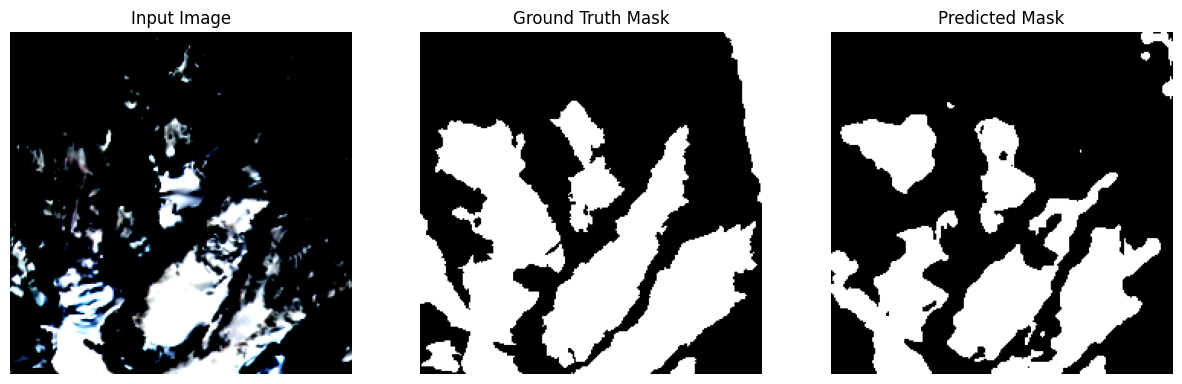

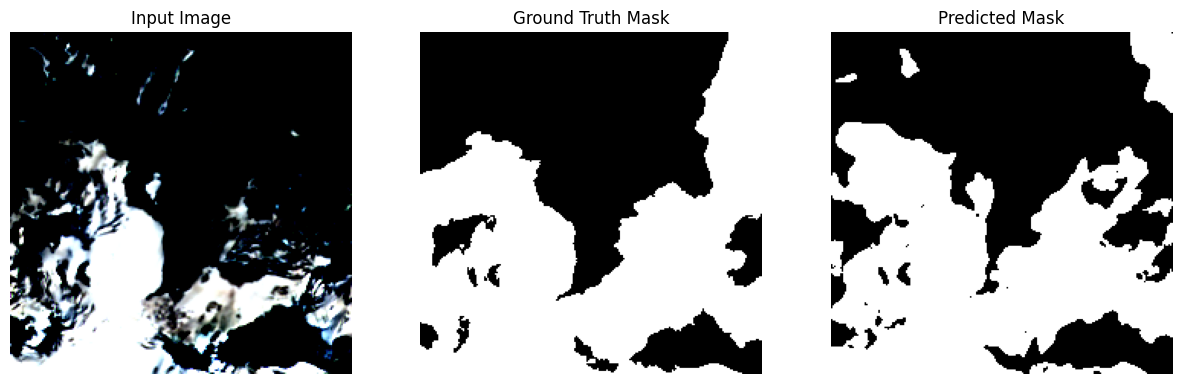

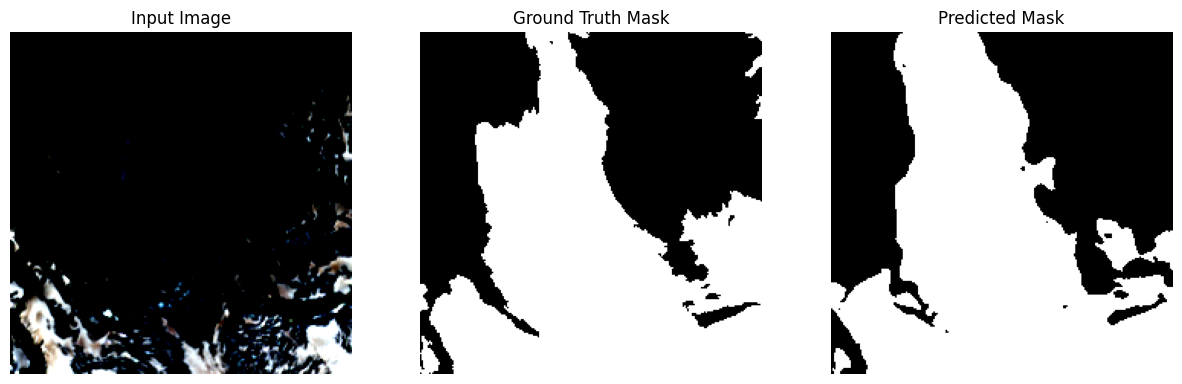

In [ ]:
# Log 2 random predictions for both models
random.seed(42)
random_indices = random.sample(range(len(imgs)), 2)
for idx in random_indices:
    img = test_ds_unet.denormalize(test_ds_unet[idx][0]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    mask = results["unet"]["masks"][idx]
    pred_u = results["unet"]["preds"][idx]
    pred_d = results["dino"]["preds"][idx]

    # Create a figure with 4 subplots: image, ground truth mask, predicted masks
    fig, axs = plt.subplots(1, 4, figsize=(16, 8))
    axs[0].imshow(img)
    axs[0].set_title("Input Image")
    axs[0].axis("off")
    axs[1].imshow(mask.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")
    axs[2].imshow(pred_u.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[2].set_title("Predicted Mask for UNet")
    axs[2].axis("off")
    axs[3].imshow(pred_d.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    axs[3].set_title("Predicted Mask for Dino")
    axs[3].axis("off")
plt.tight_layout()
plt.show()
